In [1]:
from matplotlib import pyplot as plt
%matplotlib widget
from eitprocessing.datahandling.continuousdata import ContinuousData
from eitprocessing.datahandling.eitdata import EITData
from eitprocessing.datahandling.datacollection import DataCollection
from eitprocessing.datahandling.loading import load_eit_data
from eitprocessing.filters.butterworth_filters import LowPassFilter
from eitprocessing.parameters.eeli import EELI
from eitprocessing.parameters.tidal_impedance_variation import TIV
from eitprocessing.features.breath_detection import BreathDetection
from scipy.ndimage import label
import numpy as np

In [2]:
# Define standard parameters
NUM_HORIZONTAL_REGIONS = 2  # Number of horizontal regions to divide the lung area
NUM_VERTICAL_REGIONS = 1  # Number of vertical regions to divide the lung area
FRAMERATE = 20  # Standard framerate
PIXEL_MASK_THRESHOLD = (
    0.15  # Threshold for pixel dZ for pixels to be considered involved in ventilation
)
MINUTE = 60

In [3]:
sequence = load_eit_data(
    "/Users/juliettefrancovich/Documents/KT/TM2/EMC stage 1/Data/C031.bin",
    vendor="draeger",
)

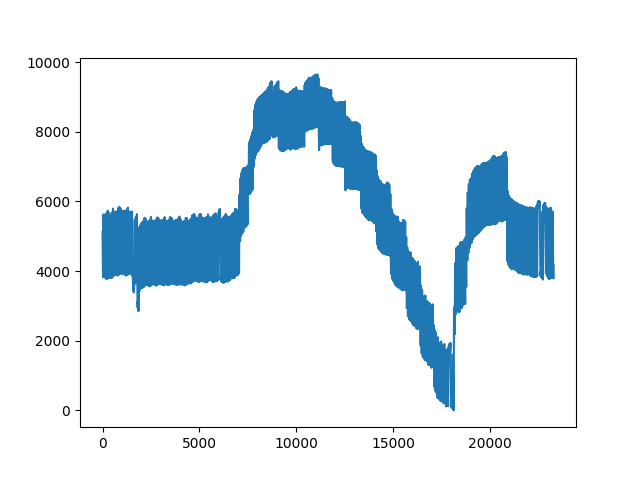

In [4]:
plt.figure()
plt.plot(sequence.continuous_data["global_impedance_(raw)"])

In [5]:
sequence = sequence.t[59200:59229]

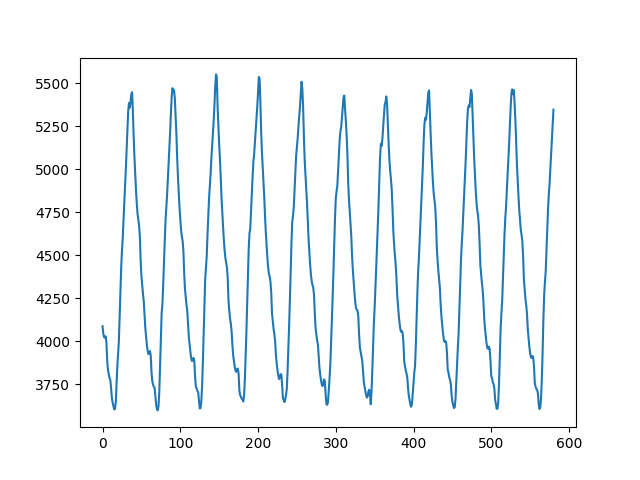

In [6]:
plt.figure()
plt.plot(sequence.continuous_data["global_impedance_(raw)"])

In [7]:
pixel_impedance = sequence.eit_data["raw"].pixel_impedance
filter_params = {
    "sample_frequency": sequence.eit_data["raw"].framerate,
    "cutoff_frequency": 50 / MINUTE,
    "order": 10,
}
filter_ = LowPassFilter(**filter_params)


filtered_pixel_impedance = filter_.apply_filter(pixel_impedance, axis=0)

In [8]:
sequence.eit_data.add(
    EITData(
        path="/Users/juliettefrancovich/Documents/KT/TM2/EMC stage 1/Data/C031.bin",
        nframes=581,
        time=sequence.eit_data["raw"].time,
        framerate=sequence.eit_data["raw"].framerate,
        vendor="draeger",
        phases=sequence.eit_data["raw"].phases,
        events=sequence.eit_data["raw"].events,
        label="low pass filtered",
        pixel_impedance=filtered_pixel_impedance,
    )
)

In [9]:
tiv_result_pixel_inspiratory = TIV().compute_pixel_parameter(
    sequence, "low pass filtered"
)

In [10]:
tiv_map = tiv_result_pixel_inspiratory["mean"]

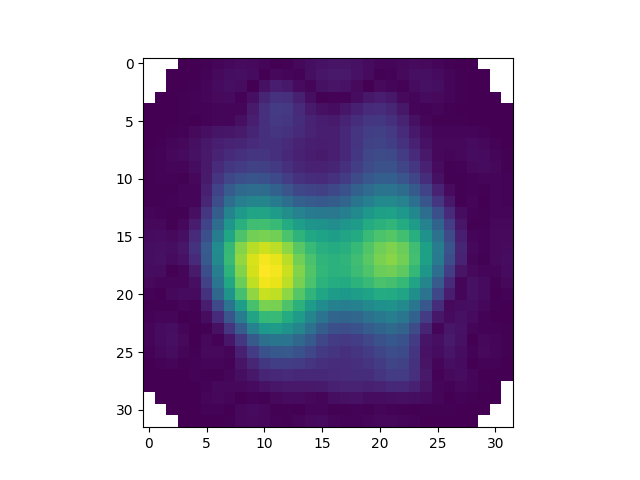

In [11]:
plt.figure()
plt.imshow(tiv_map)

In [12]:
def find_largest_cluster(pixel_matrix):
    """Find largest cluster of adjacent pixels in a pixel map

    Args:
        pixel_matrix (np.ndarray): np.ndarray representing a (n,m) pixel matrix

    Returns:
        largest_cluster (np.ndarray): (n,m) np.ndarray with binary values (0 or 1)
            Can be multiplied with the original input matrix to multiply pixels
            in the largest cluster by 1 and pixels outside the largest cluster by
            0.
    """

    # Create a mask for NaN values
    nan_mask = np.isnan(pixel_matrix)

    # Set NaN values to 0, and all other values to 1
    thresholded_matrix = np.where(nan_mask, 0, 1).astype(int)

    # Label connected regions
    labeled_matrix, num_labels = label(thresholded_matrix)

    # Find the size of each labeled region
    sizes = np.bincount(labeled_matrix.ravel())

    # Get the label of the largest region (excluding background label 0)
    largest_label = np.argmax(sizes[1:]) + 1

    # Extract the largest cluster
    largest_cluster = (labeled_matrix == largest_label).astype(int)

    return largest_cluster

In [13]:
def lung_segmentation(
    tiv_map, threshold_value=PIXEL_MASK_THRESHOLD, remove_clusters=False
):
    segmented_tiv_map = tiv_map.copy()
    max_dZ = np.nanmax(segmented_tiv_map)
    # Remove signals from pixels that are below threshold of the maximum dZ.
    segmented_tiv_map[segmented_tiv_map < threshold_value * max_dZ] = np.nan

    if remove_clusters:
        # Select only largest cluster of adjacent pixels and remove others
        largest_cluster = find_largest_cluster(segmented_tiv_map)
        segmented_tiv_map *= largest_cluster
        # num_excluded_pix = len(exclude[0])
        num_included_pix = np.sum(largest_cluster)
    else:
        num_included_pix = np.sum(segmented_tiv_map)

    return segmented_tiv_map, num_included_pix, max_dZ

In [14]:
segmented_tiv_map, num_included_pix, max_dZ = lung_segmentation(
    tiv_map, PIXEL_MASK_THRESHOLD
)